<a href="https://colab.research.google.com/github/sr6awi/ieee_fraud_detection/blob/main/notebooks/03_Preprocessing_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import os
import warnings
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings('ignore')


# === Define project paths ===
BASE_DIR = Path("/content/drive/MyDrive/ML_Projects/ieee-fraud-detection")
DATA_DIR = BASE_DIR / "raw"
PROCESSED_DIR = BASE_DIR / "processed"
ARTIFACT_DIR = BASE_DIR / "artifacts/missing_reports"

# Create directories if they don't exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# === Global constants ===
THRESHOLD = 0.80   # 80% missing threshold
SEED = 42

# === Display settings ===
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

print("✅ Configuration complete!")
print(f"📂 Data path : {DATA_DIR}")
print(f"📂 Processed : {PROCESSED_DIR}")
print(f"📋 Artifacts : {ARTIFACT_DIR}")

✅ Configuration complete!
📂 Data path : /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/raw
📂 Processed : /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/processed
📋 Artifacts : /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/artifacts/missing_reports


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define file paths
PATHS = {
    "train_transaction": DATA_DIR / "train_transaction.csv",
    "train_identity":    DATA_DIR / "train_identity.csv",
    "test_transaction":  DATA_DIR / "test_transaction.csv",
    "test_identity":     DATA_DIR / "test_identity.csv",
}

# Print the paths to be checked
print("Checking for files at the following paths:")
for name, path in PATHS.items():
    print(f"- {name}: {path}")

# Load datasets
datasets = {}
for name, path in PATHS.items():
    if not path.exists():
        raise FileNotFoundError(f"❌ File not found: {path}")

    print(f"📥 Loading {name}...")
    df = pd.read_csv(path, low_memory=False)
    datasets[name] = df
    print(f"   → shape: {df.shape}")

print(f"\n✅ All {len(datasets)} datasets loaded successfully!")
print(f"Total records: {sum(len(df) for df in datasets.values()):,}")

Checking for files at the following paths:
- train_transaction: /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/raw/train_transaction.csv
- train_identity: /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/raw/train_identity.csv
- test_transaction: /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/raw/test_transaction.csv
- test_identity: /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/raw/test_identity.csv
📥 Loading train_transaction...
   → shape: (590540, 394)
📥 Loading train_identity...
   → shape: (144233, 41)
📥 Loading test_transaction...
   → shape: (506691, 393)
📥 Loading test_identity...
   → shape: (141907, 41)

✅ All 4 datasets loaded successfully!
Total records: 1,383,371


In [ ]:
def standardize_column_names(df):
    """Convert all hyphenated column names to underscores"""
    df_clean = df.copy()
    df_clean.columns = df_clean.columns.str.replace('-', '_')
    return df_clean

# Apply standardization to all datasets
print("🔧 Standardizing column names...")
for name, df in datasets.items():
    old_cols = df.columns.tolist()[:5]
    datasets[name] = standardize_column_names(df)
    new_cols = datasets[name].columns.tolist()[:5]

    if old_cols != new_cols:
        print(f"   {name}: Fixed column names")
        print(f"      Before: {old_cols}")
        print(f"      After:  {new_cols}")

print("\n✅ Column names standardized!")

🔧 Standardizing column names...
   test_identity: Fixed column names
      Before: ['TransactionID', 'id-01', 'id-02', 'id-03', 'id-04']
      After:  ['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04']

✅ Column names standardized!


In [ ]:
def compute_missing_report(df, name, threshold=THRESHOLD):
    """Compute missingness count and percentage for each feature"""
    n = len(df)
    missing_count = df.isna().sum()
    missing_pct = (missing_count / n).round(4)

    report = pd.DataFrame({
        "feature": df.columns,
        "dtype": df.dtypes.astype(str).values,
        "n_missing": missing_count.values,
        "pct_missing": missing_pct.values
    }).sort_values("pct_missing", ascending=False).reset_index(drop=True)

    report["over_threshold"] = report["pct_missing"] > threshold
    return report

# Analyze and save reports
columns_to_drop = {}

print("🔍 Analyzing missing values...\n")
for name, df in datasets.items():
    print(f"📊 {name}:")
    report = compute_missing_report(df, name)

    # Save report
    csv_path = ARTIFACT_DIR / f"{name}_missing_report.csv"
    report.to_csv(csv_path, index=False)

    # Record columns exceeding threshold
    over = report.loc[report["over_threshold"], "feature"].tolist()
    columns_to_drop[name] = over

    print(f"   → Total features: {len(df.columns)}")
    print(f"   → Over {int(THRESHOLD*100)}% missing: {len(over)}")
    print(f"   → Report saved: {csv_path.name}\n")

# Save summary JSON
json_path = ARTIFACT_DIR / "columns_over_threshold.json"
with open(json_path, "w") as f:
    json.dump(columns_to_drop, f, indent=2)

print(f"✅ Missing value analysis complete!")
print(f"📋 Summary saved to: {json_path}")

🔍 Analyzing missing values...

📊 train_transaction:
   → Total features: 394
   → Over 80% missing: 55
   → Report saved: train_transaction_missing_report.csv

📊 train_identity:
   → Total features: 41
   → Over 80% missing: 9
   → Report saved: train_identity_missing_report.csv

📊 test_transaction:
   → Total features: 393
   → Over 80% missing: 52
   → Report saved: test_transaction_missing_report.csv

📊 test_identity:
   → Total features: 41
   → Over 80% missing: 9
   → Report saved: test_identity_missing_report.csv

✅ Missing value analysis complete!
📋 Summary saved to: /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/artifacts/missing_reports/columns_over_threshold.json


In [ ]:
cleaned_datasets = {}

print("🗑️ Dropping high-missing columns...\n")
for name, df in datasets.items():
    before_shape = df.shape
    drop_cols = columns_to_drop.get(name, [])

    # Drop columns
    df_cleaned = df.drop(columns=drop_cols, errors="ignore")
    cleaned_datasets[name] = df_cleaned

    after_shape = df_cleaned.shape

    print(f"📦 {name}:")
    print(f"   → Before: {before_shape}")
    print(f"   → After:  {after_shape}")
    print(f"   → Dropped: {len(drop_cols)} columns\n")

# Summary table
summary_data = []
for name in datasets.keys():
    summary_data.append({
        "dataset": name,
        "original_cols": datasets[name].shape[1],
        "cleaned_cols": cleaned_datasets[name].shape[1],
        "dropped": len(columns_to_drop.get(name, []))
    })

summary_df = pd.DataFrame(summary_data)
print("📊 Summary:")
print(summary_df.to_string(index=False))
print("\n✅ Column dropping complete!")

🗑️ Dropping high-missing columns...

📦 train_transaction:
   → Before: (590540, 394)
   → After:  (590540, 339)
   → Dropped: 55 columns

📦 train_identity:
   → Before: (144233, 41)
   → After:  (144233, 32)
   → Dropped: 9 columns

📦 test_transaction:
   → Before: (506691, 393)
   → After:  (506691, 341)
   → Dropped: 52 columns

📦 test_identity:
   → Before: (141907, 41)
   → After:  (141907, 32)
   → Dropped: 9 columns

📊 Summary:
          dataset  original_cols  cleaned_cols  dropped
train_transaction            394           339       55
   train_identity             41            32        9
 test_transaction            393           341       52
    test_identity             41            32        9

✅ Column dropping complete!


In [ ]:
imputation_summary = {}

print("🔢 Imputing numeric features with median...\n")

for name, df in cleaned_datasets.items():
    df_imputed = df.copy()
    num_cols = df_imputed.select_dtypes(include=[np.number]).columns

    summary = {}
    filled_count = 0

    for col in tqdm(num_cols, desc=f"  {name}", leave=False):
        n_missing = df_imputed[col].isna().sum()
        if n_missing > 0:
            median_val = df_imputed[col].median()
            df_imputed[col] = df_imputed[col].fillna(median_val)
            summary[col] = int(n_missing)
            filled_count += n_missing

    imputation_summary[name] = {"numeric_filled": summary}
    cleaned_datasets[name] = df_imputed

    print(f"✓ {name}: Filled {filled_count:,} numeric values")

print("\n✅ Numeric imputation complete!")

🔢 Imputing numeric features with median...



✓ train_transaction: Filled 64,230,006 numeric values


✓ train_identity: Filled 577,404 numeric values


✓ test_transaction: Filled 48,645,858 numeric values


✓ test_identity: Filled 573,019 numeric values

✅ Numeric imputation complete!


In [ ]:
print("📝 Imputing categorical features...\n")

for name, df in cleaned_datasets.items():
    df_imputed = df.copy()
    cat_cols = df_imputed.select_dtypes(include=["object"]).columns

    cat_summary = {}
    filled_count = 0

    for col in cat_cols:
        n_missing = df_imputed[col].isna().sum()
        if n_missing > 0:
            # Use mode if available, otherwise "missing"
            if df_imputed[col].dropna().nunique() > 0:
                mode_val = df_imputed[col].mode()[0]
                df_imputed[col] = df_imputed[col].fillna(mode_val)
            else:
                df_imputed[col] = df_imputed[col].fillna("missing")

            cat_summary[col] = int(n_missing)
            filled_count += n_missing

    imputation_summary[name]["categorical_filled"] = cat_summary
    cleaned_datasets[name] = df_imputed

    print(f"✓ {name}: Filled {filled_count:,} categorical values")

# Verify no missing values remain
print("\n🔍 Verification:")
for name, df in cleaned_datasets.items():
    total_missing = df.isna().sum().sum()
    print(f"   {name}: {total_missing} missing values")

print("\n✅ Categorical imputation complete!")

📝 Imputing categorical features...

✓ train_transaction: Filled 3,204,208 categorical values
✓ train_identity: Filled 274,624 categorical values
✓ test_transaction: Filled 2,387,365 categorical values
✓ test_identity: Filled 300,392 categorical values

🔍 Verification:
   train_transaction: 0 missing values
   train_identity: 0 missing values
   test_transaction: 0 missing values
   test_identity: 0 missing values

✅ Categorical imputation complete!


In [ ]:
print("💾 Saving standalone imputed datasets for crash recovery...\n")

# Train and test transaction / identity
imputed_to_save = {
    "train_transaction": cleaned_datasets["train_transaction"],
    "train_identity":    cleaned_datasets["train_identity"],
    "test_transaction":  cleaned_datasets["test_transaction"],
    "test_identity":     cleaned_datasets["test_identity"],
}

for name, df in imputed_to_save.items():
    out_path = PROCESSED_DIR / f"{name}_imputed.csv"
    df.to_csv(out_path, index=False)
    size_mb = round(out_path.stat().st_size / (1024 * 1024), 2)
    print(f"✓ {out_path.name:<30} ({size_mb:>7.2f} MB, {df.shape[0]:,} rows × {df.shape[1]} cols)")

print("\n✅ All imputed datasets saved successfully.")

💾 Saving standalone imputed datasets for crash recovery...

✓ train_transaction_imputed.csv  ( 798.52 MB, 590,540 rows × 339 cols)
✓ train_identity_imputed.csv     (  28.35 MB, 144,233 rows × 32 cols)
✓ test_transaction_imputed.csv   ( 692.49 MB, 506,691 rows × 341 cols)
✓ test_identity_imputed.csv      (  27.85 MB, 141,907 rows × 32 cols)

✅ All imputed datasets saved successfully.


In [ ]:
print("💾 Saving imputed datasets...\n")

for name, df in cleaned_datasets.items():
    out_path = PROCESSED_DIR / f"{name}_imputed.csv"
    df.to_csv(out_path, index=False)

    file_size = out_path.stat().st_size / (1024 * 1024)  # MB
    print(f"✓ Saved: {out_path.name}")
    print(f"   Size: {file_size:.2f} MB")
    print(f"   Shape: {df.shape}\n")

# Save imputation summary
imputation_json = ARTIFACT_DIR / "imputation_summary.json"
with open(imputation_json, "w") as f:
    json.dump(imputation_summary, f, indent=2)

print(f"📋 Imputation summary: {imputation_json}")
print("\n✅ All imputed files saved successfully!")

💾 Saving imputed datasets...

✓ Saved: train_transaction_imputed.csv
   Size: 798.52 MB
   Shape: (590540, 339)

✓ Saved: train_identity_imputed.csv
   Size: 28.35 MB
   Shape: (144233, 32)

✓ Saved: test_transaction_imputed.csv
   Size: 692.49 MB
   Shape: (506691, 341)

✓ Saved: test_identity_imputed.csv
   Size: 27.85 MB
   Shape: (141907, 32)

📋 Imputation summary: /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/artifacts/missing_reports/imputation_summary.json

✅ All imputed files saved successfully!


In [ ]:
print("🔗 Merging transaction and identity datasets...\n")

# Merge train datasets
train_full = pd.merge(
    cleaned_datasets["train_transaction"],
    cleaned_datasets["train_identity"],
    on="TransactionID",
    how="left",
    suffixes=("", "_dup")
)

print(f"✓ Train merge complete:")
print(f"   Transaction: {cleaned_datasets['train_transaction'].shape}")
print(f"   Identity:    {cleaned_datasets['train_identity'].shape}")
print(f"   Merged:      {train_full.shape}\n")

# Merge test datasets
test_full = pd.merge(
    cleaned_datasets["test_transaction"],
    cleaned_datasets["test_identity"],
    on="TransactionID",
    how="left",
    suffixes=("", "_dup")
)

print(f"✓ Test merge complete:")
print(f"   Transaction: {cleaned_datasets['test_transaction'].shape}")
print(f"   Identity:    {cleaned_datasets['test_identity'].shape}")
print(f"   Merged:      {test_full.shape}\n")

# Verify uniqueness
print("🔍 Verification:")
print(f"   Train unique IDs: {train_full['TransactionID'].is_unique}")
print(f"   Test unique IDs:  {test_full['TransactionID'].is_unique}")

print("\n✅ Integration complete!")

🔗 Merging transaction and identity datasets...

✓ Train merge complete:
   Transaction: (590540, 339)
   Identity:    (144233, 32)
   Merged:      (590540, 370)

✓ Test merge complete:
   Transaction: (506691, 341)
   Identity:    (141907, 32)
   Merged:      (506691, 372)

🔍 Verification:
   Train unique IDs: True
   Test unique IDs:  True

✅ Integration complete!


In [ ]:
def add_identity_flag(df):
    """Add binary flag indicating if transaction has identity information"""
    id_cols = [c for c in df.columns if c.startswith("id_")]

    if not id_cols:
        df["has_identity"] = 0
    else:
        # 1 if ANY identity column has a value, 0 otherwise
        df["has_identity"] = df[id_cols].notna().any(axis=1).astype(int)

    return df

def fill_merge_nans(df, name):
    """Fill NaNs introduced by left merge"""
    df_filled = df.copy()

    # Get column types
    num_cols = df_filled.select_dtypes(include=[np.number]).columns
    cat_cols = df_filled.select_dtypes(exclude=[np.number]).columns

    # Fill numeric with 0, categorical with "missing"
    df_filled[num_cols] = df_filled[num_cols].fillna(0)
    df_filled[cat_cols] = df_filled[cat_cols].fillna("missing")

    remaining = df_filled.isna().sum().sum()
    print(f"   {name}: {remaining} NaNs remaining after fill")

    return df_filled

print("🏷️ Adding identity flags and filling merge-level NaNs...\n")

# Add flags
train_full = add_identity_flag(train_full)
test_full = add_identity_flag(test_full)

print(f"✓ Train - has_identity: {train_full['has_identity'].sum():,} / {len(train_full):,}")
print(f"✓ Test  - has_identity: {test_full['has_identity'].sum():,} / {len(test_full):,}\n")

# Fill merge-level NaNs
train_full = fill_merge_nans(train_full, "train_full")
test_full = fill_merge_nans(test_full, "test_full")

print("\n✅ Identity flags added and merge NaNs filled!")

🏷️ Adding identity flags and filling merge-level NaNs...

✓ Train - has_identity: 144,233 / 590,540
✓ Test  - has_identity: 141,907 / 506,691

   train_full: 0 NaNs remaining after fill
   test_full: 0 NaNs remaining after fill

✅ Identity flags added and merge NaNs filled!


In [ ]:
print("💾 Saving integrated datasets...\n")

# Save train
train_path = PROCESSED_DIR / "train_integrated.csv"
train_full.to_csv(train_path, index=False)
train_size = train_path.stat().st_size / (1024 * 1024)

print(f"✓ train_integrated.csv")
print(f"   Path:  {train_path}")
print(f"   Size:  {train_size:.2f} MB")
print(f"   Shape: {train_full.shape}\n")

# Save test
test_path = PROCESSED_DIR / "test_integrated.csv"
test_full.to_csv(test_path, index=False)
test_size = test_path.stat().st_size / (1024 * 1024)

print(f"✓ test_integrated.csv")
print(f"   Path:  {test_path}")
print(f"   Size:  {test_size:.2f} MB")
print(f"   Shape: {test_full.shape}\n")

# Summary
print("📊 Integration Summary:")
print(f"   Total features: {train_full.shape[1]}")
print(f"   Train records:  {len(train_full):,}")
print(f"   Test records:   {len(test_full):,}")

print("\n✅ Integrated datasets saved successfully!")

💾 Saving integrated datasets...

✓ train_integrated.csv
   Path:  /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/processed/train_integrated.csv
   Size:  905.21 MB
   Shape: (590540, 371)

✓ test_integrated.csv
   Path:  /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/processed/test_integrated.csv
   Size:  784.23 MB
   Shape: (506691, 373)

📊 Integration Summary:
   Total features: 371
   Train records:  590,540
   Test records:   506,691

✅ Integrated datasets saved successfully!


In [ ]:
def encode_categoricals(df, name, encoding_maps=None):
    """
    Encode categorical columns with proper error handling
    Returns: (encoded_df, encoding_maps)
    """
    if encoding_maps is None:
        encoding_maps = {}

    df_encoded = df.copy()
    cat_cols = df_encoded.select_dtypes(exclude=[np.number]).columns

    print(f"\n🔤 Encoding {len(cat_cols)} categorical columns in {name}...")

    for col in tqdm(cat_cols, desc=f"  Encoding", leave=False):
        try:
            unique_count = df_encoded[col].nunique(dropna=False)

            # Low cardinality → Label Encoding
            if unique_count <= 20:
                le = LabelEncoder()
                df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

                encoding_maps[col] = {
                    "type": "label",
                    "n_categories": int(unique_count)
                }

            # High cardinality → Frequency Encoding
            else:
                freq = df_encoded[col].value_counts(dropna=False)
                df_encoded[col] = df_encoded[col].map(freq).fillna(0).astype(int)

                encoding_maps[col] = {
                    "type": "frequency",
                    "n_categories": int(unique_count)
                }

        except Exception as e:
            print(f"   ⚠️ Error encoding {col}: {str(e)}")
            continue

    print(f"✓ {name} encoding complete")
    return df_encoded, encoding_maps

# Initialize encoding maps
encoding_maps = {}

# Encode train
train_encoded, encoding_maps = encode_categoricals(
    train_full,
    "train_full",
    encoding_maps
)

# Encode test
test_encoded, encoding_maps = encode_categoricals(
    test_full,
    "test_full",
    encoding_maps
)

print(f"\n✅ Categorical encoding complete!")
print(f"   Encoded features: {len(encoding_maps)}")


🔤 Encoding 29 categorical columns in train_full...


✓ train_full encoding complete

🔤 Encoding 29 categorical columns in test_full...


✓ test_full encoding complete

✅ Categorical encoding complete!
   Encoded features: 29


In [ ]:

print("💾 Saving encoded datasets...\n")

# Save train encoded
train_enc_path = PROCESSED_DIR / "train_encoded.csv"
train_encoded.to_csv(train_enc_path, index=False)
train_enc_size = train_enc_path.stat().st_size / (1024 * 1024)

print(f"✓ train_encoded.csv")
print(f"   Path:  {train_enc_path}")
print(f"   Size:  {train_enc_size:.2f} MB")
print(f"   Shape: {train_encoded.shape}\n")

# Save test encoded
test_enc_path = PROCESSED_DIR / "test_encoded.csv"
test_encoded.to_csv(test_enc_path, index=False)
test_enc_size = test_enc_path.stat().st_size / (1024 * 1024)

print(f"✓ test_encoded.csv")
print(f"   Path:  {test_enc_path}")
print(f"   Size:  {test_enc_size:.2f} MB")
print(f"   Shape: {test_encoded.shape}\n")

# Save encoding maps
encoding_path = ARTIFACT_DIR / "encoding_maps.json"
with open(encoding_path, "w") as f:
    json.dump(encoding_maps, f, indent=2)

print(f"✓ encoding_maps.json")
print(f"   Path: {encoding_path}")
print(f"   Features encoded: {len(encoding_maps)}")

# Count encoding types
label_count = sum(1 for v in encoding_maps.values() if v["type"] == "label")
freq_count = sum(1 for v in encoding_maps.values() if v["type"] == "frequency")

print(f"\n📊 Encoding Summary:")
print(f"   Label encoding:     {label_count} features")
print(f"   Frequency encoding: {freq_count} features")

print("\n✅ All encoded files saved successfully!")

💾 Saving encoded datasets...

✓ train_encoded.csv
   Path:  /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/processed/train_encoded.csv
   Size:  855.95 MB
   Shape: (590540, 371)

✓ test_encoded.csv
   Path:  /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/processed/test_encoded.csv
   Size:  741.93 MB
   Shape: (506691, 373)

✓ encoding_maps.json
   Path: /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/artifacts/missing_reports/encoding_maps.json
   Features encoded: 29

📊 Encoding Summary:
   Label encoding:     23 features
   Frequency encoding: 6 features

✅ All encoded files saved successfully!


In [ ]:
print("=" * 70)
print("📋 PREPROCESSING PIPELINE - FINAL VERIFICATION")
print("=" * 70)

# Check for missing values
print("\n🔍 Missing Value Check:")
train_missing = train_encoded.isna().sum().sum()
test_missing = test_encoded.isna().sum().sum()
print(f"   Train: {train_missing} missing values")
print(f"   Test:  {test_missing} missing values")

if train_missing == 0 and test_missing == 0:
    print("   ✅ No missing values detected!")
else:
    print("   ⚠️ Warning: Missing values still present")

# Check data types
print("\n📊 Data Type Distribution:")
train_types = train_encoded.dtypes.value_counts()
for dtype, count in train_types.items():
    print(f"   {dtype}: {count} columns")

# Check for infinite values
print("\n∞ Infinite Value Check:")
train_inf = np.isinf(train_encoded.select_dtypes(include=[np.number])).sum().sum()
test_inf = np.isinf(test_encoded.select_dtypes(include=[np.number])).sum().sum()
print(f"   Train: {train_inf} infinite values")
print(f"   Test:  {test_inf} infinite values")

# Summary statistics
print("\n📈 Dataset Summary:")
summary_table = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Rows": [len(train_encoded), len(test_encoded)],
    "Columns": [train_encoded.shape[1], test_encoded.shape[1]],
    "Numeric": [
        len(train_encoded.select_dtypes(include=[np.number]).columns),
        len(test_encoded.select_dtypes(include=[np.number]).columns)
    ],
    "Target": ["isFraud" in train_encoded.columns, False]
})
print(summary_table.to_string(index=False))

# File inventory
print("\n📁 Generated Files:")
files_created = [
    "train_imputed.csv",
    "test_imputed.csv",
    "train_integrated.csv",
    "test_integrated.csv",
    "train_encoded.csv",
    "test_encoded.csv"
]

for filename in files_created:
    filepath = PROCESSED_DIR / filename
    if filepath.exists():
        size = filepath.stat().st_size / (1024 * 1024)
        print(f"   ✓ {filename:<25} ({size:>7.2f} MB)")
    else:
        print(f"   ✗ {filename:<25} (MISSING)")

print("\n" + "=" * 70)
print("✅ PREPROCESSING COMPLETE - DATA IS MODEL-READY!")
print("=" * 70)

print("\n🎯 Next Steps:")
print("   1. Load train_encoded.csv and test_encoded.csv")
print("   2. Split train data into train/validation sets")
print("   3. Begin feature engineering or model training")
print("   4. Refer to encoding_maps.json for feature interpretations")

📋 PREPROCESSING PIPELINE - FINAL VERIFICATION

🔍 Missing Value Check:
   Train: 0 missing values
   Test:  0 missing values
   ✅ No missing values detected!

📊 Data Type Distribution:
   float64: 337 columns
   int64: 34 columns

∞ Infinite Value Check:
   Train: 0 infinite values
   Test:  0 infinite values

📈 Dataset Summary:
Dataset   Rows  Columns  Numeric  Target
  Train 590540      371      371    True
   Test 506691      373      373   False

📁 Generated Files:
   ✗ train_imputed.csv         (MISSING)
   ✗ test_imputed.csv          (MISSING)
   ✓ train_integrated.csv      ( 905.21 MB)
   ✓ test_integrated.csv       ( 784.23 MB)
   ✓ train_encoded.csv         ( 855.95 MB)
   ✓ test_encoded.csv          ( 741.93 MB)

✅ PREPROCESSING COMPLETE - DATA IS MODEL-READY!

🎯 Next Steps:
   1. Load train_encoded.csv and test_encoded.csv
   2. Split train data into train/validation sets
   3. Begin feature engineering or model training
   4. Refer to encoding_maps.json for feature interpret

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
import os

PROCESSED_DIR = Path("/content/drive/MyDrive/ML_Projects/ieee-fraud-detection/processed")

train_encoded = pd.read_csv(PROCESSED_DIR / "train_encoded.csv")
test_encoded  = pd.read_csv(PROCESSED_DIR / "test_encoded.csv")

print("Train shape:", train_encoded.shape)
print("Test shape :", test_encoded.shape)


Train shape: (590540, 371)
Test shape : (506691, 373)


Low-Variance Filter

In [ ]:
X = train_encoded.drop(columns=['isFraud'])
y = train_encoded['isFraud']

# Apply low-variance filter
var_thresh = VarianceThreshold(threshold=0.01)
X_reduced = var_thresh.fit_transform(X)
low_var_cols = X.columns[var_thresh.get_support()]

train_lowvar = pd.DataFrame(X_reduced, columns=low_var_cols)
train_lowvar['isFraud'] = y.values
test_lowvar = test_encoded[low_var_cols].copy()

print(f"Removed {X.shape[1] - len(low_var_cols)} low-variance features.")
print(f"Train shape after low variance: {train_lowvar.shape}")
print(f"Test shape after low variance : {test_lowvar.shape}")

Removed 25 low-variance features.
Train shape after low variance: (590540, 346)
Test shape after low variance : (506691, 345)


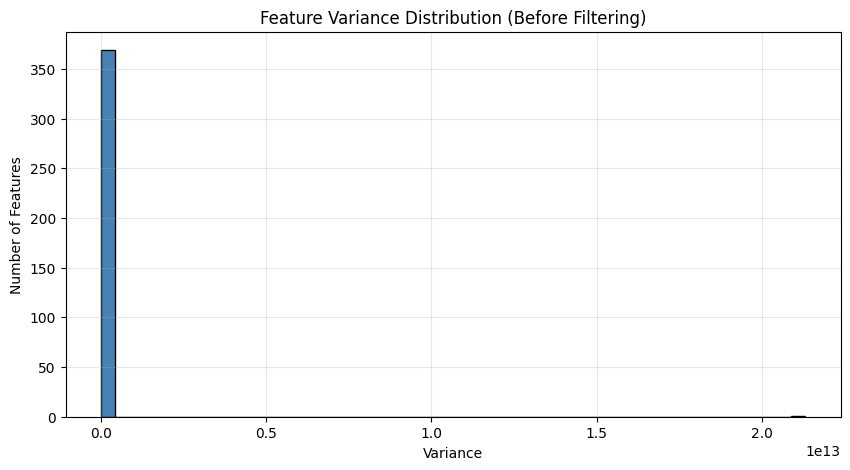

In [ ]:
import matplotlib.pyplot as plt

variances = train_encoded.drop(columns=['isFraud']).var().sort_values(ascending=False)

plt.figure(figsize=(10,5))
plt.hist(variances, bins=50, color='steelblue', edgecolor='k')
plt.title("Feature Variance Distribution (Before Filtering)")
plt.xlabel("Variance")
plt.ylabel("Number of Features")
plt.grid(alpha=0.3)
plt.show()


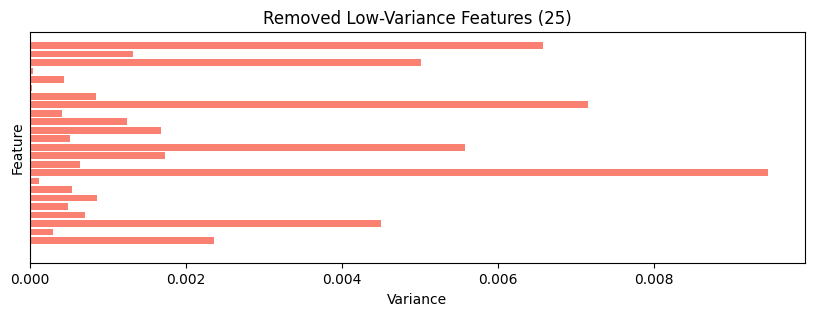

In [ ]:
before_cols = set(train_encoded.columns) - {'isFraud'}
after_cols = set(train_lowvar.columns) - {'isFraud'}
removed_lowvar = list(before_cols - after_cols)

plt.figure(figsize=(10,3))
plt.barh(range(len(removed_lowvar)), [train_encoded[col].var() for col in removed_lowvar], color='salmon')
plt.title(f"Removed Low-Variance Features ({len(removed_lowvar)})")
plt.xlabel("Variance")
plt.ylabel("Feature")
plt.yticks([])
plt.show()

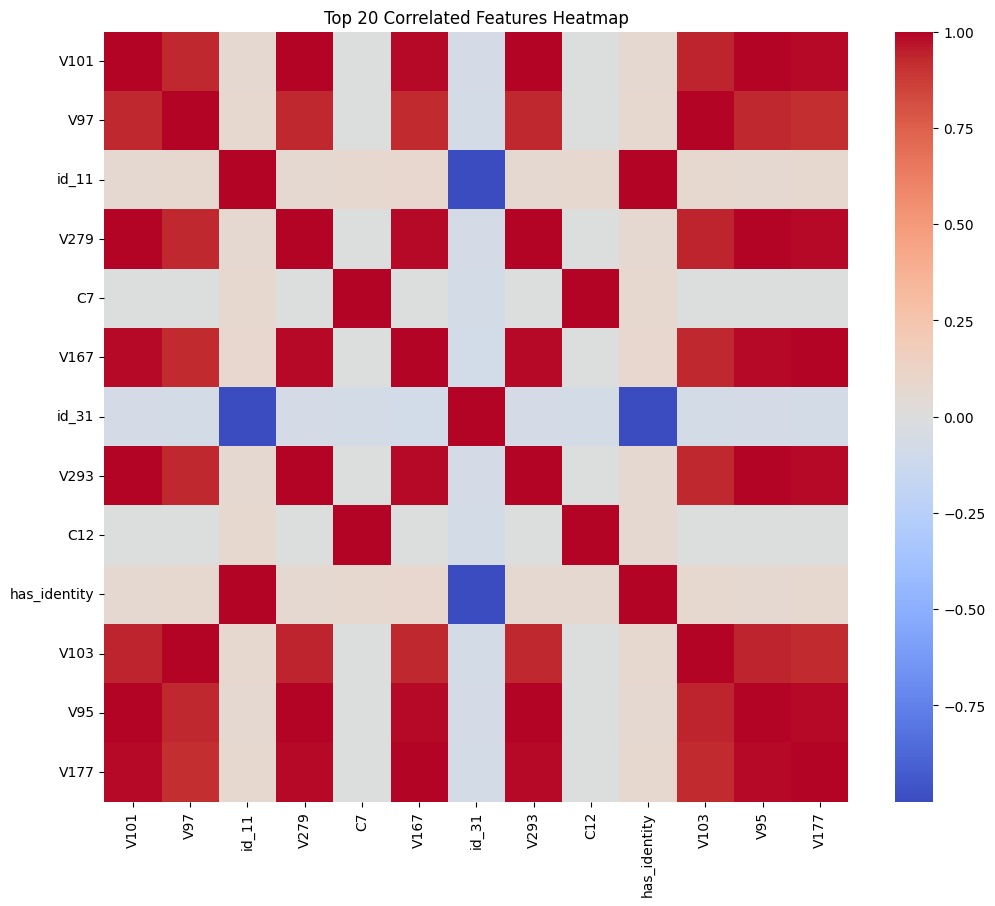

In [ ]:
import seaborn as sns

# Select only numeric columns (excluding target)
corr_data = train_lowvar.drop(columns=['isFraud']).corr().abs()

# Get top 20 correlated pairs
corr_unstacked = corr_data.unstack().sort_values(ascending=False)
top_pairs = corr_unstacked[(corr_unstacked < 1.0)].head(20)

# Extract unique feature names
top_features = list(set([i for i, j in top_pairs.index] + [j for i, j in top_pairs.index]))
plt.figure(figsize=(12,10))
sns.heatmap(train_lowvar[top_features].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Top 20 Correlated Features Heatmap")
plt.show()

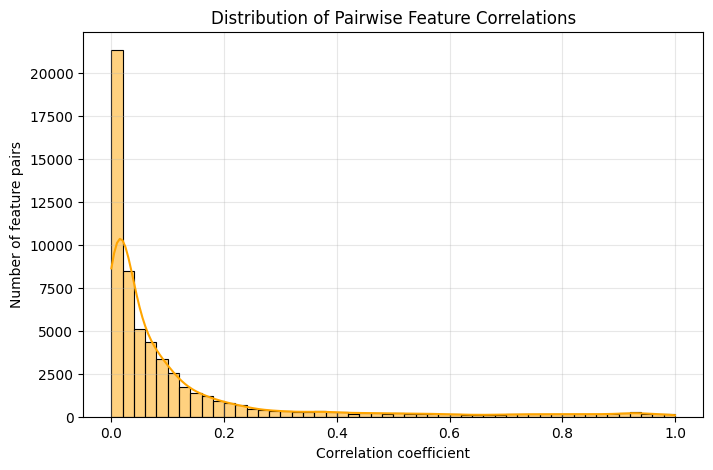

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix (use your post-variance dataset)
corr_matrix = train_lowvar.drop(columns=['isFraud']).corr().abs()

# Keep only upper triangle (avoid duplicates/self-correlations)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Flatten and drop NaNs
corr_values = upper.unstack().dropna().values

# Plot histogram
plt.figure(figsize=(8,5))
sns.histplot(corr_values, bins=50, color='orange', kde=True)
plt.title("Distribution of Pairwise Feature Correlations")
plt.xlabel("Correlation coefficient")
plt.ylabel("Number of feature pairs")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
print(f"Pairs with corr > 0.8: {(corr_values > 0.8).sum()}")
print(f"Pairs with corr > 0.9: {(corr_values > 0.9).sum()}")


Pairs with corr > 0.8: 1678
Pairs with corr > 0.9: 946


Correlation Filtering (Feature Reduction)

In [ ]:
import numpy as np

# Compute correlation matrix for numeric features
corr_matrix = train_lowvar.drop(columns=['isFraud']).corr().abs()

# Create upper triangle mask (to avoid duplicate comparisons)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify features with correlation > 0.9
threshold = 0.9
high_corr_features = [col for col in upper.columns if any(upper[col] > threshold)]

# Drop them
train_reduced = train_lowvar.drop(columns=high_corr_features)
test_reduced  = test_lowvar.drop(columns=high_corr_features)

print(f"✅ Removed {len(high_corr_features)} highly correlated features.")
print(f"Train shape after correlation filtering: {train_reduced.shape}")
print(f"Test shape after correlation filtering: {test_reduced.shape}")

# Optional: show top 10 dropped columns for review
print("\nTop correlated columns removed:")
print(high_corr_features[:10])

✅ Removed 164 highly correlated features.
Train shape after correlation filtering: (590540, 182)
Test shape after correlation filtering: (506691, 181)

Top correlated columns removed:
['TransactionDT', 'C2', 'C4', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']


In [ ]:
from pathlib import Path

PROCESSED_DIR = Path("/content/drive/MyDrive/ML_Projects/ieee-fraud-detection/processed")

train_reduced.to_csv(PROCESSED_DIR / "train_reduced.csv", index=False)
test_reduced.to_csv(PROCESSED_DIR / "test_reduced.csv", index=False)

print("✅ Final reduced datasets saved!")
print(f"Train: {train_reduced.shape}")
print(f"Test : {test_reduced.shape}")

✅ Final reduced datasets saved!
Train: (590540, 182)
Test : (506691, 181)
